In [24]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns


In [3]:
datasets_dir = os.path.join(os.getcwd(), 'datasets')
file_name = 'AABA_2006-01-01_to_2018-01-01.csv'
file_path = os.path.join(datasets_dir, file_name)
df = pd.read_csv(file_path)


inspecting the dataset

In [4]:
print(df.head())
print ("****************************************************************************")
print(df.info())
print ("****************************************************************************")
print(df.describe())
print ("*****************************************************************************")


         Date   Open   High    Low  Close    Volume  Name
0  2006-01-03  39.69  41.22  38.79  40.91  24232729  AABA
1  2006-01-04  41.22  41.90  40.77  40.97  20553479  AABA
2  2006-01-05  40.93  41.73  40.85  41.53  12829610  AABA
3  2006-01-06  42.88  43.57  42.80  43.21  29422828  AABA
4  2006-01-09  43.10  43.66  42.82  43.42  16268338  AABA
****************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB
None
*******************************************************************

In [5]:
print(df["High"].nlargest(3))
print("***********************")
print("***********************")
print(df["Close"].nlargest(3))


print(df["High"].nsmallest(3))
print("***********************")
print("***********************")
print(df["Close"].nsmallest(3))

2993    73.25
2994    73.18
2992    73.14
Name: High, dtype: float64
***********************
***********************
2994    72.93
2992    72.85
2993    72.60
Name: Close, dtype: float64
728     9.48
727    10.01
730    10.20
Name: High, dtype: float64
***********************
***********************
727    8.95
726    9.14
728    9.39
Name: Close, dtype: float64


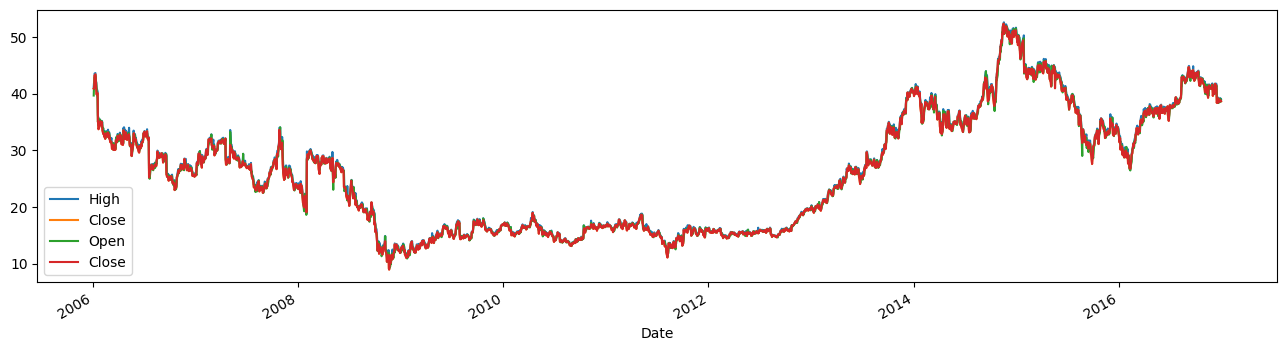

In [6]:
# Convert 'Date' column to DateTime format and set it as the index
df['Date'] = pd.to_datetime(df['Date'])  
df.set_index('Date', inplace=True)
# Now you can slice correctly
df["High"][:'2016'].plot(figsize=(16,4), legend=True)
df["Close"][:'2016'].plot(figsize=(16,4), legend=True)

df["Open"][:'2016'].plot(figsize=(16,4), legend=True)
df["Close"][:'2016'].plot(figsize=(16,4), legend=True)
plt.show()

             Open   High    Low  Close    Volume  Name
Date                                                  
2006-01-03  39.69  41.22  38.79  40.91  24232729  AABA
2006-01-04  41.22  41.90  40.77  40.97  20553479  AABA
2006-01-05  40.93  41.73  40.85  41.53  12829610  AABA
2006-01-06  42.88  43.57  42.80  43.21  29422828  AABA
2006-01-09  43.10  43.66  42.82  43.42  16268338  AABA
...           ...    ...    ...    ...       ...   ...
2016-12-23  38.46  38.81  38.37  38.66   3841245  AABA
2016-12-27  38.59  39.06  38.50  38.92   4240285  AABA
2016-12-28  39.12  39.22  38.71  38.73   4428368  AABA
2016-12-29  38.76  38.93  38.48  38.64   4170497  AABA
2016-12-30  38.72  39.00  38.43  38.67   6432792  AABA

[2768 rows x 6 columns]


array([[40.91],
       [40.97],
       [41.53],
       ...,
       [38.73],
       [38.64],
       [38.67]])

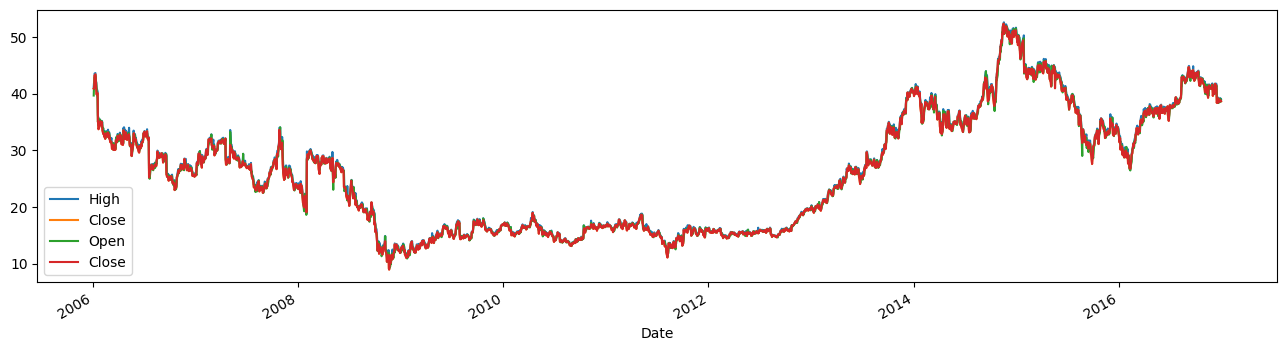

In [8]:


df["High"][:'2016'].plot(figsize=(16,4),legend=True)
df["Close"][:'2016'].plot(figsize=(16,4),legend=True)
df["Open"][:'2016'].plot(figsize=(16,4),legend=True)
df["Close"][:'2016'].plot(figsize=(16,4),legend=True)
print(df[:'2016'])
x = df[:'2016'].iloc[:,3:4].values
x



In [9]:
print(df.isnull().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64


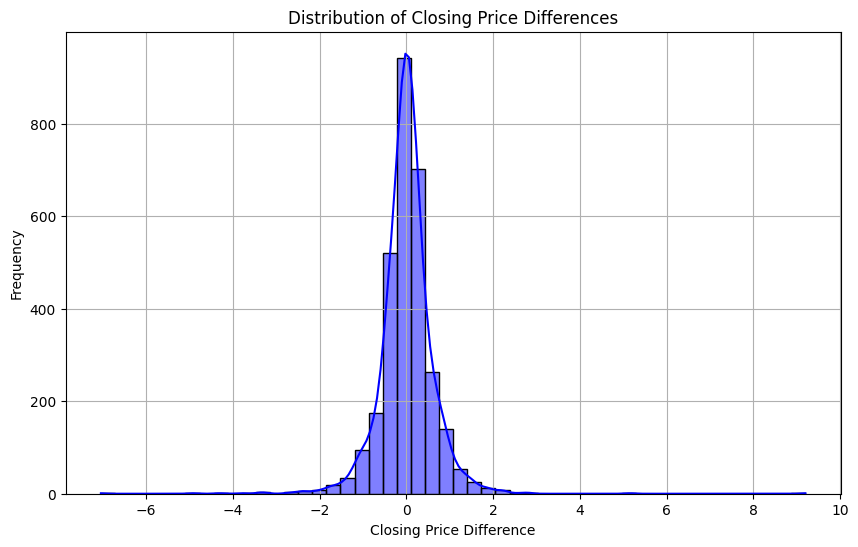

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(diff_close_series, bins=50, kde=True, color='blue')
plt.title("Distribution of Closing Price Differences")
plt.xlabel("Closing Price Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig("distribution_closing_price_diff.png", dpi=300)  # Save for LaTeX
plt.show()

In [10]:
diff_close_series = df['Close'].diff().dropna()

# Create lagged features from differences
lagged_data = pd.concat(
    [diff_close_series.shift(i) for i in range(5, -1, -1)],
    axis=1
).dropna()
lagged_data.columns = [f'lag_{i}' for i in range(5, -1, -1)]

# Split into 50% train and 50% test
split_idx = int(len(lagged_data) * 0.6)
train_data = lagged_data.iloc[:split_idx]
test_data = lagged_data.iloc[split_idx:]


In [11]:
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

In [12]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [13]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [14]:
model = Sequential()
model.add(Input(shape=(X_train_reshaped.shape[1], 1)))  # Explicit input layer
model.add(LSTM(50, return_sequences=False))
model.add(LeakyReLU(negative_slope=0.01))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


2025-03-25 03:42:31.892099: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [15]:
model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=8, verbose=1)


Epoch 1/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0116
Epoch 2/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8283
Epoch 3/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7595
Epoch 4/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1272
Epoch 5/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5278
Epoch 6/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1967
Epoch 7/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1556
Epoch 8/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0733
Epoch 9/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0787
Epoch 10/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9352
Epoch 11/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1637
Epoch 12/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0307
Epoch 13/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9621
Epoch 14/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4435
Epoch 15/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 0

In [16]:
y_train_pred_scaled = model.predict(X_train_reshaped)
y_test_pred_scaled = model.predict(X_test_reshaped)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [17]:
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

In [45]:

mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

In [47]:
print(f"train MSE: {mse_train:.6f}")
print(f"train RMSE: {rmse_train:.6f}")
print(f"train r2: {r2_train:.6f}")


train MSE: 0.056911
train RMSE: 0.238561
train r2: 0.824778


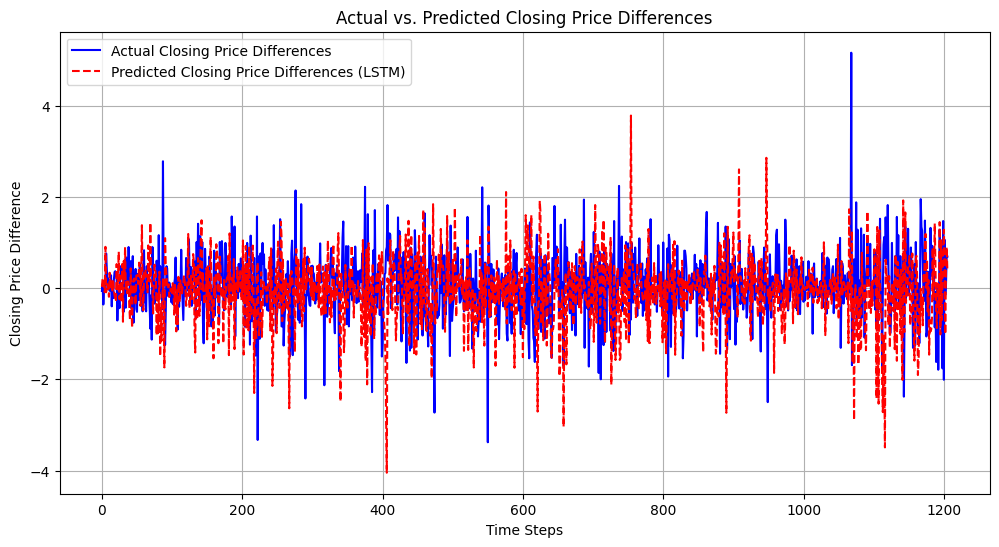

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Closing Price Differences', linestyle='-', color='blue')
plt.plot(y_test_pred, label='Predicted Closing Price Differences (LSTM)', linestyle='dashed', color='red')

plt.title("Actual vs. Predicted Closing Price Differences")
plt.xlabel("Time Steps")
plt.ylabel("Closing Price Difference")
plt.legend()
plt.grid(True)
plt.savefig("actual_vs_predicted.png", dpi=300)  
plt.show()


sarima

In [27]:
sarima_model = SARIMAX(y_train, order=(5, 1, 0), seasonal_order=(1, 1, 1, 11)) 
sarima_fit = sarima_model.fit(disp=False)
y_train_pred_sarima = sarima_fit.predict(start=0, end=len(y_train) - 1)
y_test_pred_sarima = sarima_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

In [28]:
mse_train_sarima = mean_squared_error(y_train, y_train_pred_sarima)
r2_train_sarima = r2_score(y_train, y_train_pred_sarima)
mae_train_sarima = mean_absolute_error(y_train, y_train_pred_sarima)

mse_test_sarima = mean_squared_error(y_test, y_test_pred_sarima)
r2_test_sarima = r2_score(y_test, y_test_pred_sarima)
mae_test_sarima = mean_absolute_error(y_test, y_test_pred_sarima)

In [29]:
print("\nSARIMA Results:")
print(f"Train MSE: {mse_train_sarima:.6f}, Train R2: {r2_train_sarima:.6f}, Train MAE: {mae_train_sarima:.6f}")
print(f"Test MSE: {mse_test_sarima:.6f}, Test R2: {r2_test_sarima:.6f}, Test MAE: {mae_test_sarima:.6f}")


SARIMA Results:
Train MSE: 0.427864, Train R2: -0.317337, Train MAE: 0.400993
Test MSE: 0.597000, Test R2: -0.185837, Test MAE: 0.583086


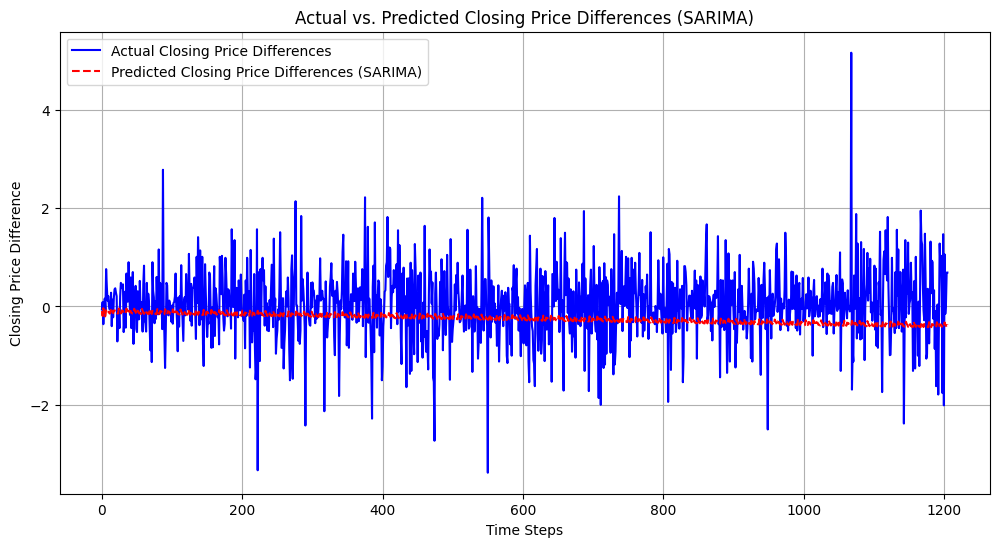

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Closing Price Differences', linestyle='-', color='blue')
plt.plot(y_test_pred_sarima, label='Predicted Closing Price Differences (SARIMA)', linestyle='dashed', color='red')

plt.title("Actual vs. Predicted Closing Price Differences (SARIMA)")
plt.xlabel("Time Steps")
plt.ylabel("Closing Price Difference")
plt.legend()
plt.grid(True)
plt.savefig("actual_vs_predicted_sarima.png", dpi=300)  
plt.show()


Random Forest

In [30]:
rf_model = RandomForestRegressor(n_estimators=500, random_state=39)
rf_model.fit(X_train, y_train)
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)


In [31]:
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)

mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)

In [32]:
print("\nRandom Forest Results:")
print(f"Train MSE: {mse_train_rf:.6f}, Train R2: {r2_train_rf:.6f}, Train MAE: {mae_train_rf:.6f}")
print(f"Test MSE: {mse_test_rf:.6f}, Test R2: {r2_test_rf:.6f}, Test MAE: {mae_test_rf:.6f}")



Random Forest Results:
Train MSE: 0.049310, Train R2: 0.848180, Train MAE: 0.134354
Test MSE: 0.562682, Test R2: -0.117670, Test MAE: 0.557398


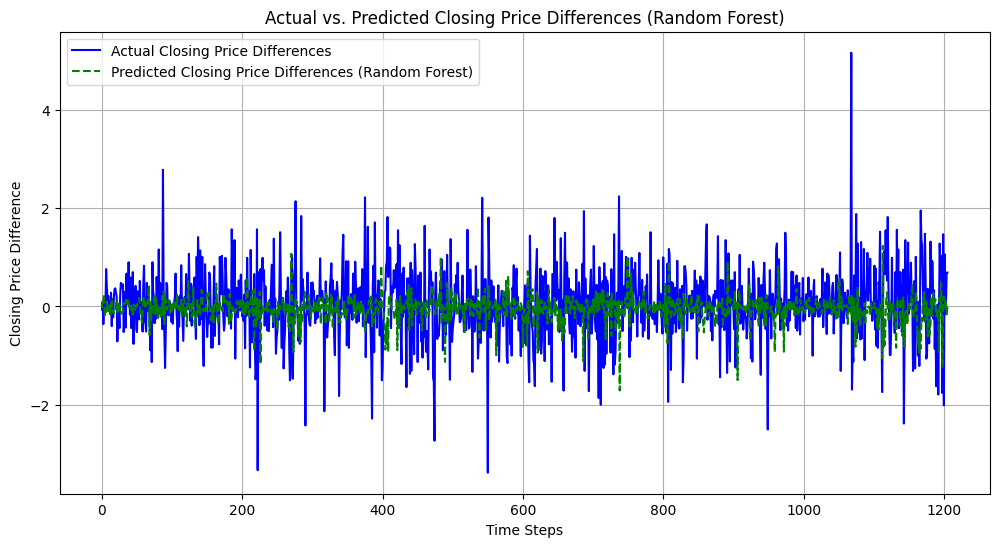

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Closing Price Differences', linestyle='-', color='blue')
plt.plot(y_test_pred_rf, label='Predicted Closing Price Differences (Random Forest)', linestyle='dashed', color='green')

plt.title("Actual vs. Predicted Closing Price Differences (Random Forest)")
plt.xlabel("Time Steps")
plt.ylabel("Closing Price Difference")
plt.legend()
plt.grid(True)
plt.savefig("actual_vs_predicted_rf.png", dpi=300)  
plt.show()


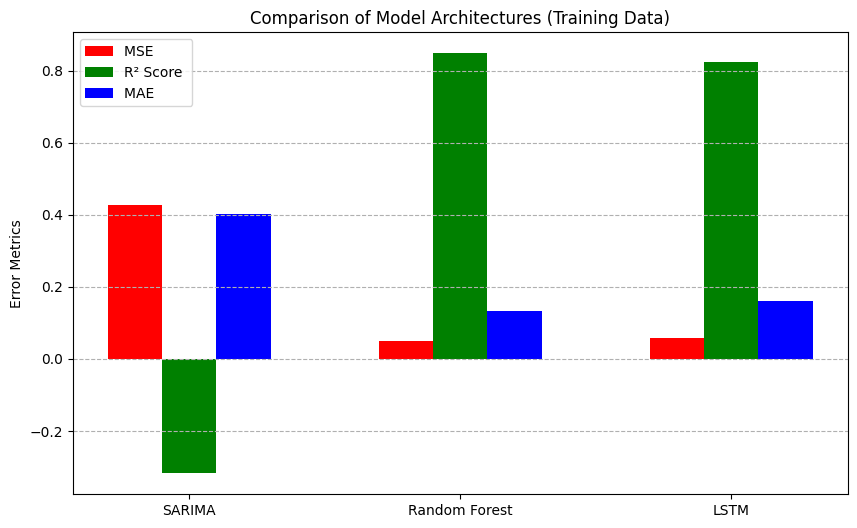

In [ ]:
models = ["SARIMA", "Random Forest", "LSTM"]
mse_values = [mse_train_sarima, mse_train_rf, mean_squared_error(y_train, y_train_pred)]
r2_values = [r2_train_sarima, r2_train_rf, r2_score(y_train, y_train_pred)]
mae_values = [mae_train_sarima, mae_train_rf, mean_absolute_error(y_train, y_train_pred)]

x = np.arange(len(models))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, mse_values, 0.2, label="MSE ", color='red')
plt.bar(x, r2_values, 0.2, label="R² Score ", color='green')
plt.bar(x + 0.2, mae_values, 0.2, label="MAE ", color='blue')

plt.xticks(x, models)
plt.title("Comparison of Model Architectures (Training Data)")
plt.ylabel("Error Metrics")
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.savefig("model_comparison_train.png", dpi=300)
plt.show()
